### Вручтель Серафима. 495. Применение решающего дерева.

In [3]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as optimize

import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline


Загрузим датасет german credit data.

In [15]:
import pandas as pd


In [19]:
german_credit_data = pd.read_csv(r'Training50.csv')
gcd = pd.DataFrame(german_credit_data) 
gcd.head()


,Unnamed: 0,Creditability,Account.Balance,Duration.of.Credit..month.,Payment.Status.of.Previous.Credit,Purpose,Credit.Amount,Value.Savings.Stocks,Length.of.current.employment,Instalment.per.cent,...,Duration.in.Current.address,Most.valuable.available.asset,Age..years.,Concurrent.Credits,Type.of.apartment,No.of.Credits.at.this.Bank,Occupation,No.of.dependents,Telephone,Foreign.Worker
0,497,1,3,6,2,3,2108,1,3,2,...,2,1,29,2,1,1,1,1,1,1
1,756,0,1,15,1,4,950,1,4,4,...,3,3,33,2,1,2,1,2,1,1
2,580,0,1,42,2,3,7174,4,3,4,...,3,3,30,2,2,1,1,1,2,1
3,833,0,3,36,3,4,7980,4,1,4,...,4,3,27,2,1,2,1,1,2,1
4,602,1,3,24,3,2,2028,1,3,2,...,2,2,30,2,2,2,1,1,1,1


По всей видимости, target - Creditability в этой табличке

In [24]:
# Разделим данные на свойства и результат
target = gcd.Creditability
features = gcd.drop('Creditability', axis=1)


Построим решающее дерево.

In [28]:
from sklearn import tree

model_tree = tree.DecisionTreeClassifier()
model_tree.fit(features, target)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Визуализируем построенное дерево.

In [41]:
from IPython.display import Image

In [35]:
column_names = features.columns.values

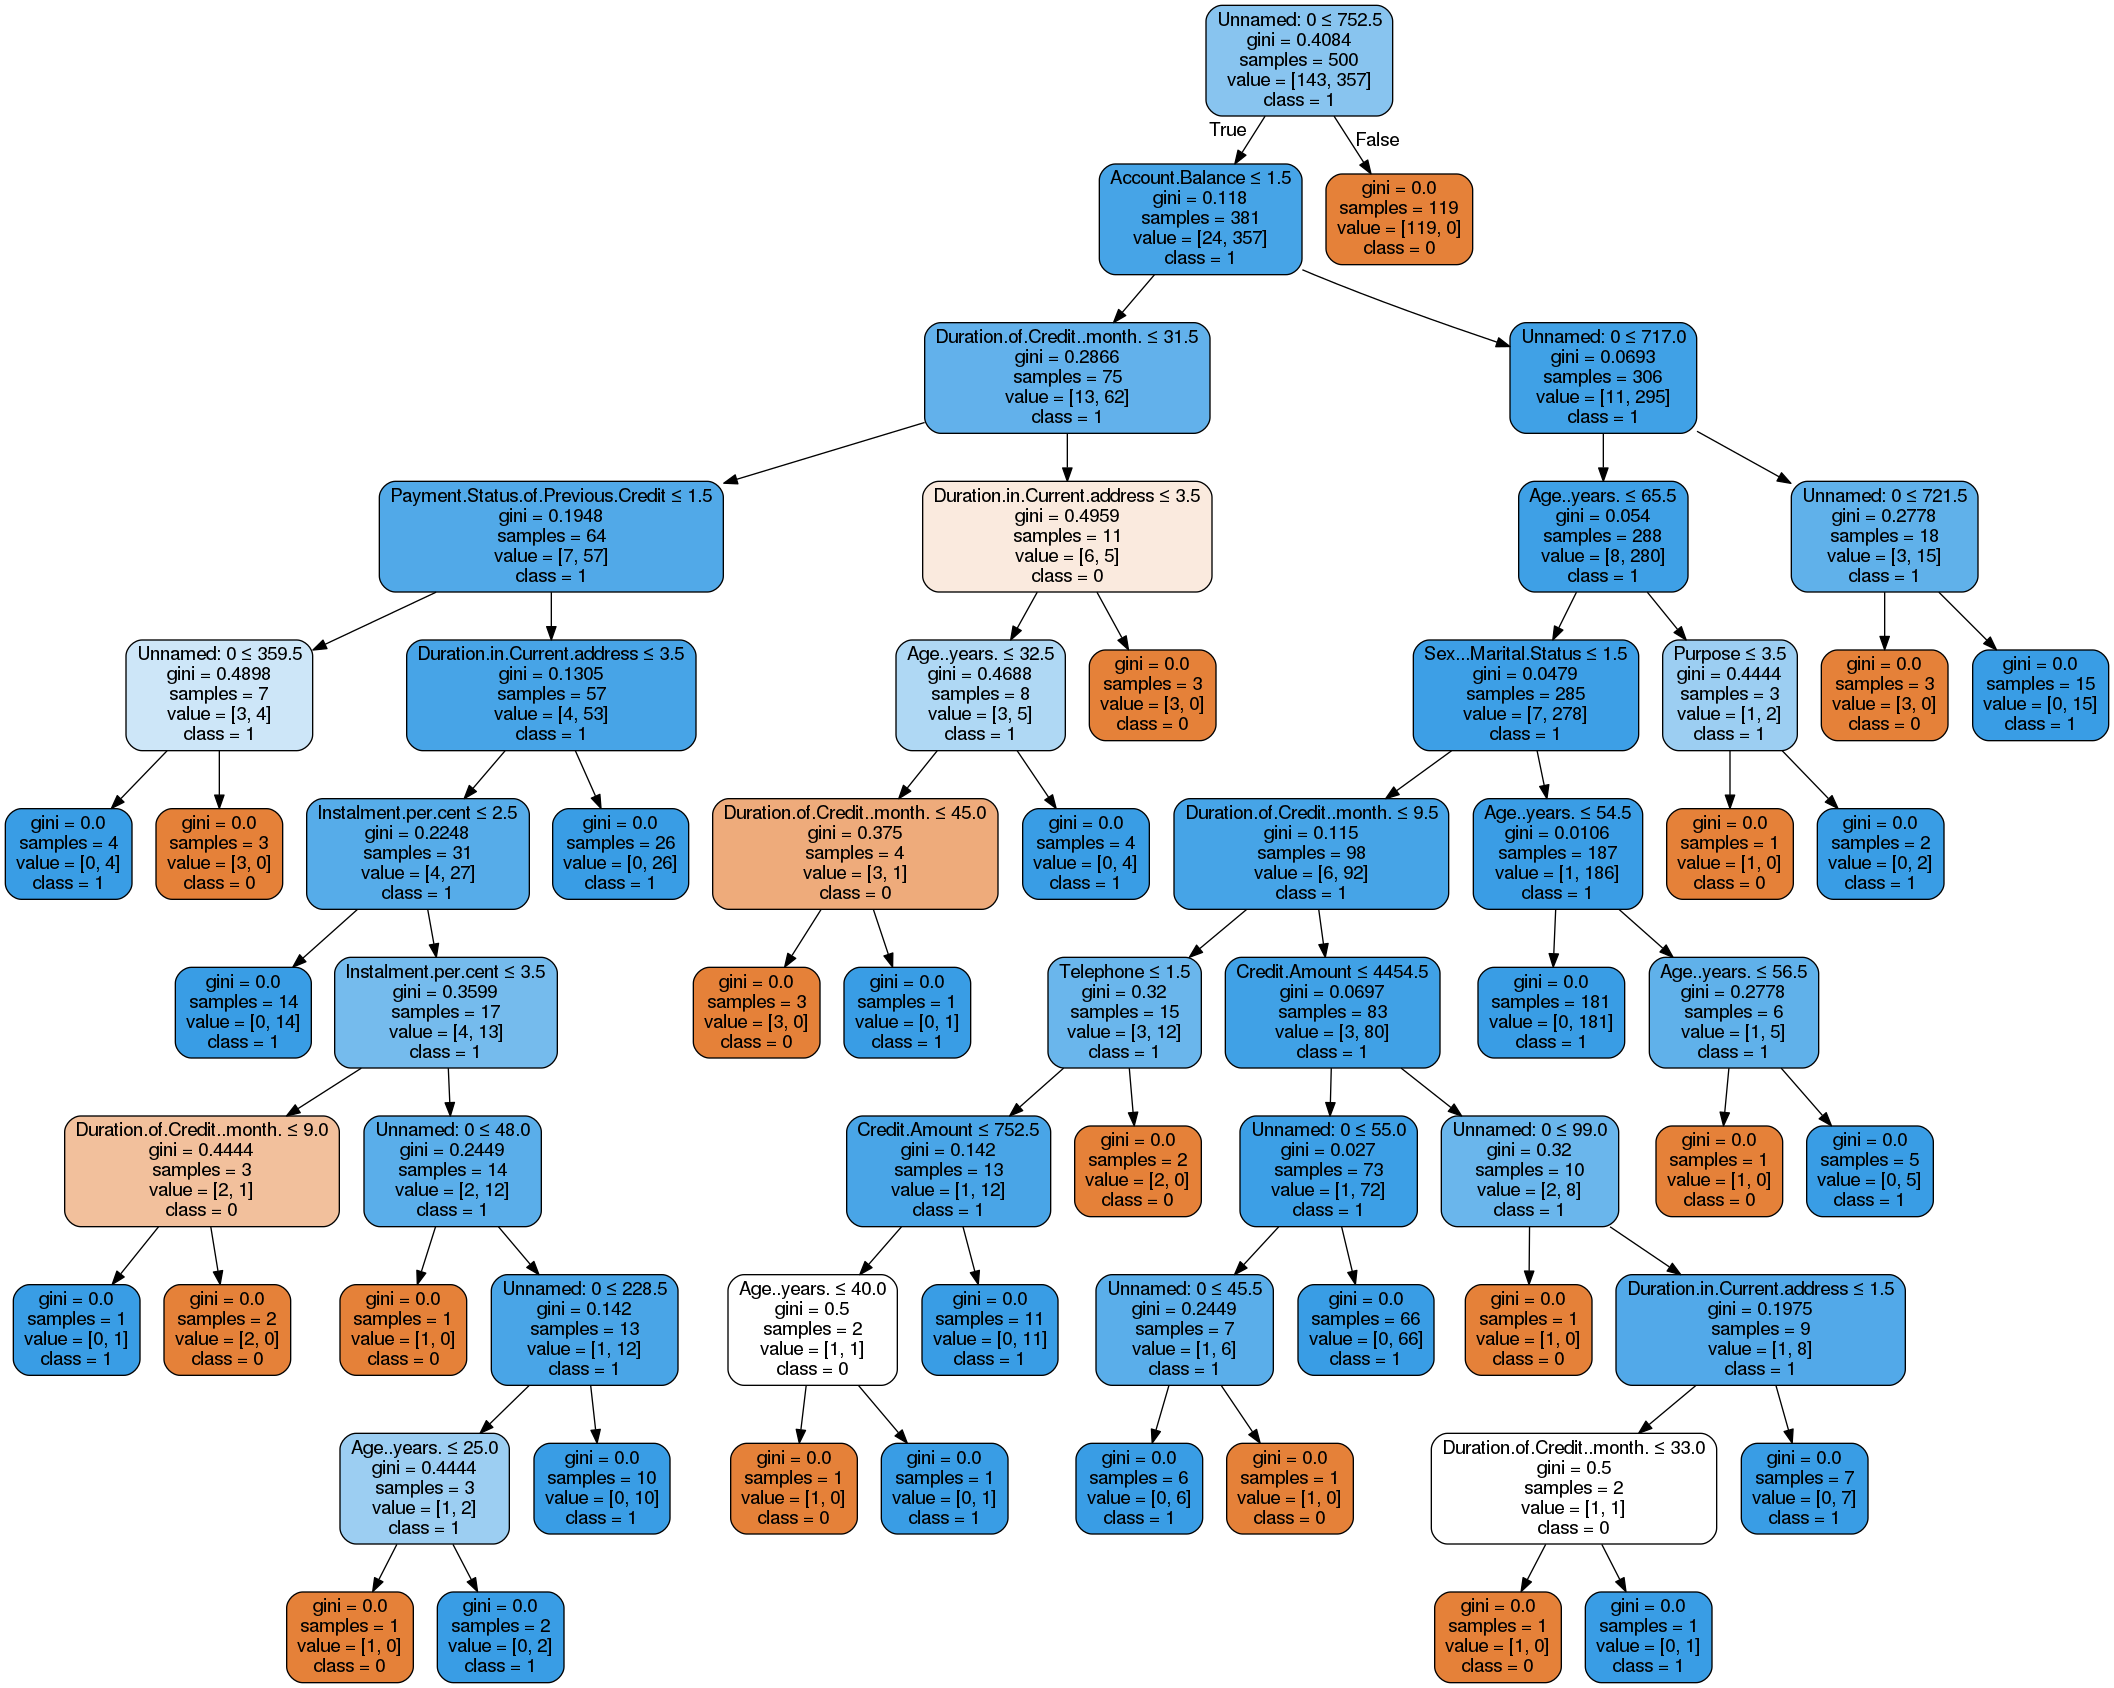

In [42]:
dot_data = tree.export_graphviz(model, out_file="big_tree.out", 
                         feature_names=column_names,  
                         class_names=np.array(["0", "1"]),  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("big_tree.out")  
Image(graph.create_png())


Попробуем интерпретировать некоторые разбиения.

В одном из узлов определяется, что если длительность кредита меньше 32 месяцев, то кредит стоит давать, а вот на более долгий срок - уже не стоит. Это в целом логично: человек, который берёт кредит на меньший срок, с большей вероятностью сможет его выплатить.

В другом из узлов определяется, что если человеку меньше 33 лет, то кредит ему давать не стоит. Это тоже разумное разбиение, ведь у людей среднего возраста кредитоспособность выше.

По результатам ещё одного из узлов получаем разбиение, согласно которому человек, живущий в данном месте меньше четырёх лет с большей вероятностью получит кредит.

***Теперь построим графики зависимости качества на кросс-валидации и на обучающей выборке от глубины дерева.***

In [44]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor


/home/serafima/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


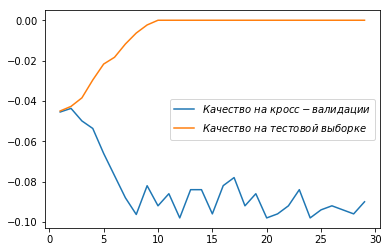

In [46]:
tree_depths = range(1, 30)

quality_cross_val = [np.mean(cross_val_score(DecisionTreeRegressor(max_depth=depth), 
                                   features, target, cv=4, 
                                   scoring='neg_mean_squared_error'))
                    for depth in tree_depths]

quality_train_set = [-metrics.mean_squared_error(target, 
                                        DecisionTreeRegressor(max_depth=depth).fit(features, target).predict(features))
                    for depth in tree_depths]

plt.plot(tree_depths, quality_cross_val, label="$Качество$ $на$ $кросс-валидации$")
plt.plot(tree_depths, quality_train_set, label="$Качество$ $на$ $тестовой$ $выборке$")
plt.legend()
plt.show()


Из графика видно, что качество на тестовой выборке существенно выше, чем на кросс-валидации.